In [1]:
!pip install "opencv-python-headless<4.3" #cv2のバージョンを4.3以下でダウンロードする、augmentationでバグが起きるからフォルダごとに考える必要がある
!pip install albumentations==1.1.0 #augmentationのライブラリ（画像を増やす）

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 24.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.0.74
    Uninstalling opencv-python-headless-4.8.0.74:
      Successfully uninstalled opencv-python-headless-4.8.0.74
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.2.1 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 3.4

In [4]:
import pandas as pd
import numpy as np
import glob
import cv2
from google.colab.patches import cv2_imshow
import datetime
t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
import random

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.dataset import Subset

import albumentations as A #augmentation(増強)
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm, trange #残り何秒か分かる
from typing import OrderedDict #辞書型に順番を決める
from sklearn.model_selection import KFold

from google.colab import drive
drive.mount('/content/drive')

DIR_PATH="/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
patch_size = 112

In [5]:
def make_augmentations(W=patch_size, H=patch_size, crop_size=patch_size):
    augmentations_dict = {
        "random_crop":A.Compose(
            [
                A.RandomCrop(width=crop_size, height=crop_size),
            ]
        ),
        "vertical_flip": A.Compose(
            [
                A.VerticalFlip(p=1.0),
            ]
        ),
        "horizontal_flip":A.Compose(
            [
                A.HorizontalFlip(p=1.0),
            ]
        ),
        "normallize": A.Compose(
            [
                ToTensorV2(),
            ]
        ),
    }
    return augmentations_dict

In [6]:
class Transform(object):
    def __init__(self,augmentations_dict=make_augmentations()):
        self.augmentations_dict=augmentations_dict

    def __call__(self, image):
        if self.augmentations_dict is not None:
          image = self.augmentations_dict["normallize"](image=image)["image"]
          image = image/255
        return image

class Transform_horizontal(object):
    def __init__(self,augmentations_dict=make_augmentations()):
        self.augmentations_dict=augmentations_dict

    def __call__(self, image):
        if self.augmentations_dict is not None:
          image = self.augmentations_dict["horizontal_flip"](image=image)["image"]
          image = self.augmentations_dict["normallize"](image=image)["image"]
          image = image/255
        return image

class Transform_vertical(object):
    def __init__(self,augmentations_dict=make_augmentations()):
        self.augmentations_dict=augmentations_dict

    def __call__(self, image):
        if self.augmentations_dict is not None:
          image = self.augmentations_dict["vertical_flip"](image=image)["image"]
          image = self.augmentations_dict["normallize"](image=image)["image"]
          image = image/255
        return image

class Transform_inverted(object):
    def __init__(self,augmentations_dict=make_augmentations()):
        self.augmentations_dict=augmentations_dict

    def __call__(self, image):
        if self.augmentations_dict is not None:
          image = self.augmentations_dict["horizontal_flip"](image=image)["image"]
          image = self.augmentations_dict["vertical_flip"](image=image)["image"]
          image = self.augmentations_dict["normallize"](image=image)["image"]
          image = image/255
        return image

In [7]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self,transform):
    self.transform = transform
    self.images = []
    self.labels = []
    self.conduction_range = [0,1]
    self.conditions = []
    sample_paths=glob.glob(f"{DIR_PATH}/*")
    for path in tqdm(sample_paths):
      sample_name=path.split("/")[-1]

      path_dict={
      key:f"{DIR_PATH}/{sample_name}/{sample_name}_{key}.bmp"
        for key in ["BC","GB","IPF"]
      }
      print(path_dict)
      image = np.dstack([cv2.imread(path) for path in path_dict.values()])

      H,W,_ = image.shape
      n_H, n_W = H//patch_size, W//patch_size
      H_, W_ = patch_size*n_H, patch_size*n_W
      image = image[:H_, :W_]

      #1枚ずつ切り出し
      #num=0
      for h in np.vsplit(image, n_H):
        for w in np.hsplit(h, n_W):
          self.images.append(w)
          label=[1 if sample_name.startswith('SPC') else 0]
          self.labels.append(label)

    #self.conditions.append(condition)
    self.labels=np.array(self.labels)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    #idxは番号
    image=self.images[idx] #np.array
    image=self.transform(image)#tensor
    image=image.to(torch.float32)#tensorのfloat32

    label=self.labels[idx]#np.array
    label=torch.Tensor(label)#Tensor
    label=label.to(torch.float32)
    return image, label

In [8]:
from torchvision import models
class ResNetBaseModel(nn.Module):
  def __init__(
       self,
       num_layer: int,
       pretrained: bool = True,
       is_BC=True,
       is_GB=True,
       is_IPF=True,
    ):
       super().__init__()
       if num_layer in [18, 34, 50, 101, 152]:
         if num_layer == 18:
            self.resnet = models.resnet18(pretrained=pretrained)
         elif num_layer == 34:
            self.resnet = models.resnet34(pretrained=pretrained)
         elif num_layer == 50:
            self.resnet = models.resnet50(pretrained=pretrained)
         elif num_layer == 101:
            self.resnet = models.resnet101(pretrained=pretrained)
         elif num_layer == 152:
            self.resnet = models.resnet152(pretrained=pretrained)
         self.out = nn.Sequential(
             nn.Linear(self.resnet.fc.in_features, 1),
             nn.Sigmoid()
         )
         self.resnet.conv1 = nn.Conv2d(9, 64, kernel_size=7, stride=2, padding=3, bias=False)
         self.resnet.fc = nn.Identity()

       else:
         raise Exception("Invalid number of ResNet layers.")

       self.is_BC=is_BC
       self.is_GB=is_GB
       self.is_IPF=is_IPF

  def forward(self, x):
    x=self.channel_setting(x)
    features = self.resnet(x)
    output = self.out(features)
    return output

  def get_features(self, x):
    features = self.resnet(x)
    return features

  def channel_setting(self,x):
    if not self.is_BC:
      x[:,0] = 0
      x[:,1] = 0
      x[:,2] = 0
    if not self.is_GB:
      x[:,3] = 0
      x[:,4] = 0
      x[:,5] = 0
    if not self.is_IPF:
      x[:,6] = 0
      x[:,7] = 0
      x[:,8] = 0
    return x

  def predict(self, sample_path, device,corner):
    self.eval()
    self.to(device)
    sample_name=sample_path.split("/")[-1]

    path_dict={
        key:f"{sample_path}/{sample_name}_{key}.bmp"
        for key in ["BC","GB","IPF"]
    }
    print(path_dict)

    image = np.dstack([cv2.imread(path) for path in path_dict.values()])
    image=image[corner[0]:corner[0]+patch_size,corner[1]:corner[1]+patch_size]

    aug = A.Compose(
        [
             ToTensorV2(),
         ]
         )

    with torch.no_grad():
      x = aug(image=image)["image"]
      x = x/255
      x = x.unsqueeze(0)
      x = x.to(torch.float32)
      x = x.to(device)
      y = self.forward(x)
      conduction = y[0][0]
      return conduction

In [11]:
trans=Transform(augmentations_dict=make_augmentations())
trans = Transform(augmentations_dict=make_augmentations())
trainval_dataset = CustomDataset(trans)

trans = Transform_horizontal(augmentations_dict=make_augmentations())
trainval_dataset += CustomDataset(trans)

trans = Transform_vertical(augmentations_dict=make_augmentations())
trainval_dataset += CustomDataset(trans)

trans = Transform_inverted(augmentations_dict=make_augmentations())
trainval_dataset += CustomDataset(trans)

  0%|          | 0/10 [00:00<?, ?it/s]

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge38/SPC-Ge38_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge36/SPC-Ge36_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge37/SPC-Ge37_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度

  0%|          | 0/10 [00:00<?, ?it/s]

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge38/SPC-Ge38_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge36/SPC-Ge36_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge37/SPC-Ge37_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度

  0%|          | 0/10 [00:00<?, ?it/s]

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge38/SPC-Ge38_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge36/SPC-Ge36_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge37/SPC-Ge37_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度

  0%|          | 0/10 [00:00<?, ?it/s]

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge38/SPC-Ge38_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge36/SPC-Ge36_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/00.学習データ/SPC-Ge37/SPC-Ge37_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度

In [12]:
count = 0
for _, i in trainval_dataset:
  count += 1
print(count)

3080


## 本学習

In [13]:
num_start=0
batch_size=32
num_layer=152
num_epoch=50
random_state=0
lr=1e-6
lr_list = [1e-6]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

num_loop=0

kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
for lr in lr_list:

  for k, (train_idx, valid_idx) in enumerate(kf.split(trainval_dataset)):
    best_loss = 1
    if num_loop>=num_start:
      print(f"try_{num_loop}:k={k}")
      train_dataset = Subset(trainval_dataset, train_idx)
      val_dataset   = Subset(trainval_dataset, valid_idx)

      # 学習用Dataloader
      train_dataloader = DataLoader(
          train_dataset,
          batch_size=batch_size, #同時に学習する問題数、大きいほうが良いがスペックと相談
          shuffle=True,
          num_workers=4,
          drop_last=True, #8,8,8,3とかが嫌なので3を除く
          pin_memory=True #よくわからんけどTrue
      )

    # 評価用Dataloader
    valid_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        drop_last=False,
        pin_memory=True
    )

    model = ResNetBaseModel(num_layer)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #Newton法みたいなもん、Adamバージョン lr:learning rateステップサイズみたいなもん
    model.to(device) #作った計算をどっちでやるか記載するだけ Returnがmodelになる

    train_loss=[]
    valid_loss=[]

    with trange(num_epoch) as pbar:
      for i in pbar:
        pbar.set_description(f'[Epoch {i + 1}/{num_epoch}]')
        model.train()#学習モード
        running_loss=[]

        for image, label in train_dataloader:
          image, label = image.to(device), label.to(device)
          optimizer.zero_grad() # 前回計算した勾配を0にする。しないと加算(RNNでは有効)
          outputs = model(image)
          #log_outputs = torch.cat([log_outputs, outputs], dim=0)
          #log_labels = torch.cat([log_labels, labels], dim=0)
          loss = criterion(outputs, label) # 損失計算
          loss.backward() # 勾配を計算
          optimizer.step() # 勾配を使ってモデルパラメータを更新
          running_loss.append(loss.item())
        train_loss.append(np.mean(running_loss))

        model.eval()#評価モード
        running_loss=[]
        with torch.no_grad():
          for image, label in valid_dataloader:
            image, label = image.to(device), label.to(device)
            outputs = model(image)
            loss = criterion(outputs, label) # 損失計算
            running_loss.append(loss.item())
        valid_loss.append(np.mean(running_loss))

        pbar.set_postfix(
            OrderedDict(
                TrainLoss=train_loss[-1],
                ValidLoss=valid_loss[-1],
            )
        )
        if best_loss>valid_loss[-1]:
          best_loss=valid_loss[-1]
          torch.save(model.state_dict(), f"/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/CNN_new_patch{patch_size}_lr={lr}_k={k}_new2.pth")
    num_loop+=1
    print(best_loss)
    pd.DataFrame(data={
      "train_loss":train_loss,
      "valid_loss":valid_loss
    }).to_csv(f"/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/CNN_new_patch{patch_size}_lr={lr}_k={k}_new2.csv", index=False)

try_0:k=0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 67.7MB/s]


  0%|          | 0/50 [00:00<?, ?it/s]

0.011509759433101863
try_1:k=1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/50 [00:00<?, ?it/s]

0.007806226328830235
try_2:k=2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

##評価（テストデータ）

In [ ]:
path_list = glob.glob('/content/drive/MyDrive/03.移動度ML/03.伝導型制御/04.MLP_train/CNN_new_lr=5e-06*.csv')
for path in path_list:
  df = pd.read_csv(path)
  print(path)
  print(df['valid_loss'].min())
  print('-------')

/content/drive/MyDrive/03.移動度ML/03.伝導型制御/04.MLP_train/CNN_new_lr=5e-06_k=1.csv
0.0010560131825817
-------
/content/drive/MyDrive/03.移動度ML/03.伝導型制御/04.MLP_train/CNN_new_lr=5e-06_k=2.csv
0.0086706965618456
-------
/content/drive/MyDrive/03.移動度ML/03.伝導型制御/04.MLP_train/CNN_new_lr=5e-06_k=3.csv
0.0043751451400263
-------
/content/drive/MyDrive/03.移動度ML/03.伝導型制御/04.MLP_train/CNN_new_lr=5e-06_k=4.csv
0.0014800480190994
-------


In [14]:
model = ResNetBaseModel(152)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.pn判定/CNN_new_patch112_lr=1e-06_k=1_new2.pth'))

<All keys matched successfully>

In [ ]:
img = cv2.imread('/content/drive/MyDrive/03.移動度ML/02.本番/00.データ/02.テストデータ/05.n型(GB分割)/NGE44/NGE44_IPF.bmp')
img.shape

(448, 1121, 3)

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.9174, device='cuda:0')
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.7750, device='cuda:0')
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.デ

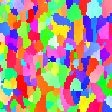

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.8074, device='cuda:0')
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.8089, device='cuda:0')
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.デ

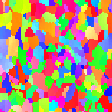

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.8008, device='cuda:0')
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.5108, device='cuda:0')
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.デ

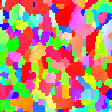

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.8719, device='cuda:0')
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.5985, device='cuda:0')
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.デ

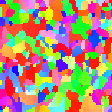

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.5448, device='cuda:0')
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.2771, device='cuda:0')


{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.7484, device='cuda:0')
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.3514, device='cuda:0')


{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.1749, device='cuda:0')


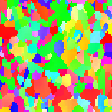

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.7332, device='cuda:0')
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_IPF.bmp'}
tensor(0.9177, device='cuda:0')
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.デ

In [18]:
image_path = '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE22'
sample_name = image_path.split('/')[-1]

p = 0
n = 0
preds_list=[]
# 画像テンソルをモデルに入力して予測を行う
for i in range(4):
  for j in range(10):
    preds = model.predict(image_path,"cuda:0" if torch.cuda.is_available() else "cpu",[int(patch_size*i),int(patch_size*j)])
    preds_list.append(preds)
    if preds > 0.5:
      img = cv2.imread(image_path+f'/{sample_name}_IPF.bmp')
      print(preds)
      img=img[int(patch_size*i):int(patch_size*i)+patch_size,int(patch_size*j):int(patch_size*j)+patch_size]
      #cv2_imshow(img)
      n += 1
    else:
      img = cv2.imread(image_path+f'/{sample_name}_IPF.bmp')
      print(preds)
      img=img[int(patch_size*i):int(patch_size*i)+patch_size,int(patch_size*j):int(patch_size*j)+patch_size]
      cv2_imshow(img)
      p += 1

print(f'p:{p}',end = ' ')
print(f'n:{n}')

In [ ]:
img = cv2.imread('/content/drive/MyDrive/03.移動度ML/02.本番/00.データ/02.テストデータ/06.p型(GB分割)/HGE40/HGE40_TB.bmp')
img.shape

(895, 1121, 3)

In [ ]:
preds_list

[array(0.00174493, dtype=float32),
 array(0.00146854, dtype=float32),
 array(0.00303096, dtype=float32),
 array(0.00747388, dtype=float32),
 array(0.00192998, dtype=float32),
 array(0.00175703, dtype=float32),
 array(0.00254037, dtype=float32),
 array(0.00308929, dtype=float32),
 array(0.00223575, dtype=float32),
 array(0.00144394, dtype=float32),
 array(0.00167615, dtype=float32),
 array(0.0009775, dtype=float32)]

In [ ]:
preds_list = [item.detach().cpu().numpy() for item in preds_list]
pd.Series(preds_list).to_csv('/content/drive/MyDrive/03.移動度ML/03.伝導型制御/result_伝導型_SPC-Ge35.csv')

In [ ]:
result_list = glob.glob('/content/drive/MyDrive/03.移動度ML/02.ノンドープ/02.普通に計算/result/*.csv')
min = 10
for filename in result_list:
  if pd.read_csv(filename)['valid_loss'].min() < min:
    min = pd.read_csv(filename)['valid_loss'].min()
    memo = filename

print(memo)

/content/drive/MyDrive/03.移動度ML/02.ノンドープ/02.普通に計算/result/result_k=2.csv


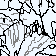

In [ ]:
img = cv2.imread(image_path+'/NGE18_GB.bmp')
img=img[56:112,56:112]
cv2_imshow(img)

In [ ]:
preds_list

[tensor(0.9321, device='cuda:0'),
 tensor(0.9809, device='cuda:0'),
 tensor(0.9951, device='cuda:0'),
 tensor(0.9720, device='cuda:0'),
 tensor(0.9296, device='cuda:0'),
 tensor(0.9821, device='cuda:0'),
 tensor(0.9940, device='cuda:0'),
 tensor(0.9973, device='cuda:0'),
 tensor(0.8605, device='cuda:0'),
 tensor(0.9361, device='cuda:0'),
 tensor(0.8722, device='cuda:0'),
 tensor(0.9726, device='cuda:0')]

In [ ]:
preds_list2 = preds_list

In [ ]:
preds_list2_numpy = [item.detach().cpu().numpy() for item in preds_list]

In [ ]:
p = 0
n = 0
for i in preds_list:
  if i > 0.5:
    n += 1
  else:
    p += 1
print(f'p{p}')
print(f'n{n}')
print(n/(p+n))

p12
n0
0.0


In [ ]:
#もともと
import matplotlib.pyplot as plt

x_list, y_list=[],[]
for x in range(len(preds_list)):
  x_list.append(preds_list[x][0])
  y_list.append(preds_list[x][1])
plt.xlim([0,250])
plt.ylim([1e18,6e18])
plt.scatter(x_list,y_list)

sum_mob = 0
sum_n   = 0
for i in range(len(preds_list)):
  sum_mob += preds_list[i][0]
  sum_n   += preds_list[i][1]

print(sum_mob/len(preds_list))
print(sum_n/len(preds_list))

IndexError: ignored

In [ ]:
#(100)
import matplotlib.pyplot as plt

x_list, y_list=[],[]
for x in range(len(preds_list)):
  x_list.append(preds_list[x][0])
  y_list.append(preds_list[x][1])
plt.xlim([0,250])
plt.ylim([1e17,1e18])
plt.scatter(x_list,y_list)

sum_mob = 0
sum_n   = 0
for i in range(len(preds_list)):
  sum_mob += preds_list[i][0]
  sum_n   += preds_list[i][1]

print(sum_mob/len(preds_list))
print(sum_n/len(preds_list))

In [ ]:
#もともと
sum_mob = 0
sum_n   = 0
for i in range(len(preds_list)):
  sum_mob += preds_list[i][0]
  sum_n   += preds_list[i][1]

mob_ave = sum_mob/len(preds_list)
n_ave   = sum_n/len(preds_list)
print(f'移動度:{mob_ave},電子密度{n_ave}')

移動度:192.66528814193614,電子密度3.7661208648280694e+18


In [ ]:
#100
sum_mob = 0
sum_n   = 0
for i in range(len(preds_list)):
  sum_mob += preds_list[i][0]
  sum_n   += preds_list[i][1]

mob_ave = sum_mob/len(preds_list)
n_ave   = sum_n/len(preds_list)
print(f'移動度:{mob_ave},電子密度{n_ave}')

移動度:216.38986645150896,電子密度4.07336269118007e+18


In [ ]:
#110
sum_mob = 0
sum_n   = 0
for i in range(len(preds_list)):
  sum_mob += preds_list[i][0]
  sum_n   += preds_list[i][1]

mob_ave = sum_mob/len(preds_list)
n_ave   = sum_n/len(preds_list)
print(f'移動度:{mob_ave},電子密度{n_ave}')

移動度:285.686413747539,電子密度5.37059469640652e+18


In [ ]:
#111
sum_mob = 0
sum_n   = 0
for i in range(len(preds_list)):
  sum_mob += preds_list[i][0]
  sum_n   += preds_list[i][1]

mob_ave = sum_mob/len(preds_list)
n_ave   = sum_n/len(preds_list)
print(f'移動度:{mob_ave},電子密度{n_ave}')

移動度:231.2894699295154,電子密度4.627812618639516e+18


In [ ]:
#111
sum_mob = 0
sum_n   = 0
for i in range(len(preds_list)):
  sum_mob += preds_list[i][0]
  sum_n   += preds_list[i][1]

mob_ave = sum_mob/len(preds_list)
n_ave   = sum_n/len(preds_list)
print(f'移動度:{mob_ave},電子密度{n_ave}')

In [ ]:
ans_DF = pd.DataFrame()
sample_name_test_list = {'SPC-Ge26', 'SPC-Ge31','SPC-Ge36', 'SPC-Ge37',  'SPC-Ge39', 'SPC-Ge40'} #'SPC-Ge38',
orientation_list ={'(100)','(110)','(111)'}
for orientation in orientation_list:
  for sample_name_test in sample_name_test_list:
    image_path = f'/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/{orientation}/{sample_name_test}'
    preds_list=[]
  # 画像テンソルをモデルに入力して予測を行う
    for i in range(14):
      for j in range(18):
        preds = model.predict(image_path,"cuda:0" if torch.cuda.is_available() else "cpu",trainval_dataset.mu_range, trainval_dataset.n_range,[int(56*i),int(56*j)])
        preds_list.append(preds)
    sum_mob = 0
    sum_n   = 0
    for i in range(len(preds_list)):
      sum_mob += preds_list[i][0]
      sum_n   += preds_list[i][1]

    mob_ave = sum_mob/len(preds_list)
    n_ave   = sum_n/len(preds_list)
    a = [[sample_name_test,orientation,mob_ave,n_ave]]
    prop_df = pd.DataFrame(a)
    ans_DF = pd.concat([ans_DF,prop_df])

print(ans_DF)

{'BC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/SPC-Ge39/SPC-Ge39_IPF.bmp', 'SB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/SPC-Ge39/SPC-Ge39_SB.bmp', 'TC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/SPC-Ge39/SPC-Ge39_TC.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/SPC-Ge39/SPC-Ge39_IPF.bmp', 'SB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/SPC-Ge39/SPC-Ge39_SB.bmp', 'TC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/S

In [ ]:
sample_name_test_list = {'SPC-Ge26', 'SPC-Ge31','SPC-Ge36', 'SPC-Ge37',  'SPC-Ge39', 'SPC-Ge40'} #'SPC-Ge38',

for sample_name_test in sample_name_test_list:
  image_path = f'/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/{sample_name_test}'
  preds_list=[]
# 画像テンソルをモデルに入力して予測を行う
  for i in range(14):
    for j in range(18):
      preds = model.predict(image_path,"cuda:0" if torch.cuda.is_available() else "cpu",trainval_dataset.mu_range, trainval_dataset.n_range,[int(56*i),int(56*j)])
      preds_list.append(preds)

  sum_mob = 0
  sum_n   = 0
  for i in range(len(preds_list)):
    sum_mob += preds_list[i][0]
    sum_n   += preds_list[i][1]

  mob_ave = sum_mob/len(preds_list)
  n_ave   = sum_n/len(preds_list)
  a = [[sample_name_test,orientation,mob_ave,n_ave]]
  prop_df = pd.DataFrame(a)
  ans_DF2 = pd.concat([ans_DF2, prop_df])

{'BC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/SPC-Ge39/SPC-Ge39_IPF.bmp', 'SB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/SPC-Ge39/SPC-Ge39_SB.bmp', 'TC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/SPC-Ge39/SPC-Ge39_TC.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/SPC-Ge39/SPC-Ge39_IPF.bmp', 'SB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/SPC-Ge39/SPC-Ge39_SB.bmp', 'TC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/SPC-Ge39/SPC-Ge39_TC.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/

In [ ]:
ans_DF2.to_csv('/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/result.csv')

In [ ]:
ans_DF2 = ans_DF

In [ ]:
ans_DF = pd.concat([prop_df,ans_DF])
ans_DF = pd.concat([prop_df,ans_DF])
ans_DF

0      1           2             3
0  SPC-Ge39  (110)  285.740406  5.371749e+18
0  SPC-Ge39  (110)  285.740406  5.371749e+18

In [ ]:
a = [[sample_name_test,orientation,mob_ave,n_ave]]
a = pd.DataFrame(a)
a = pd.concat([a,a])
ans_DF= pd.DataFrame()
a = pd.concat([ans_DF,a])
a

0      1           2             3
0  SPC-Ge39  (100)  285.740406  5.371749e+18
0  SPC-Ge39  (100)  285.740406  5.371749e+18

In [ ]:
preds_100 = model.predict('/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)',"cuda:0" if torch.cuda.is_available() else "cpu",trainval_dataset.mu_range, trainval_dataset.n_range,[0,0])
preds_110 = model.predict('/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)',"cuda:0" if torch.cuda.is_available() else "cpu",trainval_dataset.mu_range, trainval_dataset.n_range,[0,0])
preds_111 = model.predict('/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(111)',"cuda:0" if torch.cuda.is_available() else "cpu",trainval_dataset.mu_range, trainval_dataset.n_range,[0,0])
print(f'(100):{preds_100},(110):{preds_110},(111):{preds_111}')

{'BC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)/(100)_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)/(100)_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)/(100)_IPF.bmp', 'SB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)/(100)_SB.bmp', 'TC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)/(100)_TC.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/(110)_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/(110)_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/(110)_IPF.bmp', 'SB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/(110)_SB.bmp', 'TC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(110)/(110)_TC.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(111)/(111)_BC.bmp', 'GB

In [ ]:
x_step_list = [5,10,20,40,80,160,320]
y_step_list = [5,10,20,40,80,160,320]

elec_list = []
for x_step in x_step_list:
  for y_step in y_step_list:
    path=glob.glob(f'/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/02.GB無限/x{x_step}y{y_step}')
    for i in range(len(path)):
      preds = model.predict(path[i],"cuda:0" if torch.cuda.is_available() else "cpu",trainval_dataset.mu_range, trainval_dataset.n_range,[0,0])
      elec_list.append(preds)
      print(f'x{x_step},y{y_step},x*y{x_step*y_step}')
      print(f'µ:{preds[0]},n:{preds[1]}')

{'BC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/02.GB無限/x5y5/x5y5_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/02.GB無限/x5y5/x5y5_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/02.GB無限/x5y5/x5y5_IPF.bmp', 'SB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/02.GB無限/x5y5/x5y5_SB.bmp', 'TC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/02.GB無限/x5y5/x5y5_TC.bmp'}
x5,y5,x*y25
µ:212.2527292890235,n:4.1552340495037153e+18
{'BC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/02.GB無限/x5y10/x5y10_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/02.GB無限/x5y10/x5y10_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/02.GB無限/x5y10/x5y10_IPF.bmp', 'SB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/02.GB無限/x5y10/x5y10_SB.bmp', 'TC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/02.GB無限/x5y10/x5y10_TC.bmp'}
x5,y10,x*y50
µ:210.9225146009524,n:3.8345636928348273e+18
{'BC': '/

In [ ]:
hall_list=glob.glob('/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/SPC-Ge26/*.csv')
hall_list

['/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/SPC-Ge26/SPC-Ge26_Hall.csv']

In [ ]:
image=cv2.imread('/content/drive/MyDrive/03.移動度ML/01.As-doped/テストデータ/NGE18/NGE18_BC.bmp')
image.shape

(818, 1024, 3)

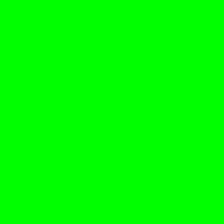

In [ ]:
#ブランク画像
height = 224
width = 224
blue = np.zeros((height, width, 3))
blue += [0,0,255][::-1]
red = np.zeros((height, width, 3))
red += [255,0,0][::-1]
green = np.zeros((height, width, 3))
green += [0,255,0][::-1]

cv2_imshow(green)

In [ ]:
sum_mob = 0
sum_n   = 0
for i in range(len(preds_list)):
  sum_mob += preds_list[i][0]
  sum_n   += preds_list[i][1]

print(sum_mob/len(preds_list))
print(sum_n/len(preds_list))

141.53431515298132
2.717719419055459e+18


195.69977837513667
3.986041042534603e+18


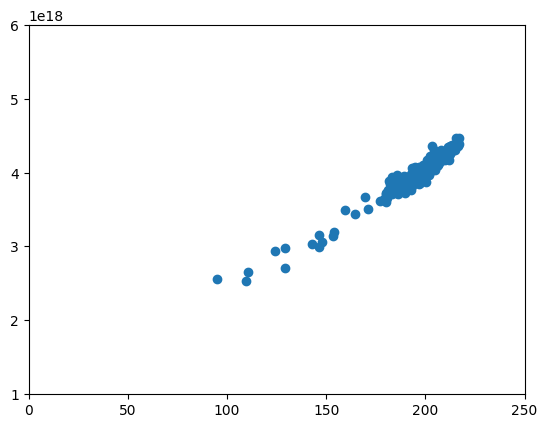

In [ ]:
#もともと
import matplotlib.pyplot as plt

x_list, y_list=[],[]
for x in range(len(preds_list)):
  x_list.append(preds_list[x][0])
  y_list.append(preds_list[x][1])
plt.xlim([0,250])
plt.ylim([1e18,6e18])
plt.scatter(x_list,y_list)

sum_mob = 0
sum_n   = 0
for i in range(len(preds_list)):
  sum_mob += preds_list[i][0]
  sum_n   += preds_list[i][1]

print(sum_mob/len(preds_list))
print(sum_n/len(preds_list))

141.53431515298132
2.717719419055459e+18


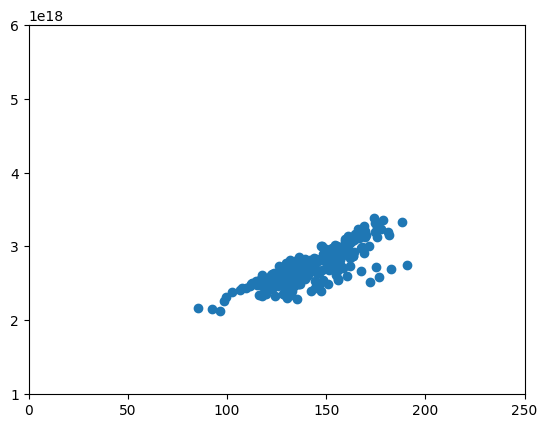

In [ ]:
#(100)
import matplotlib.pyplot as plt

x_list, y_list=[],[]
for x in range(len(preds_list)):
  x_list.append(preds_list[x][0])
  y_list.append(preds_list[x][1])
plt.xlim([0,250])
plt.ylim([1e18,6e18])
plt.scatter(x_list,y_list)

sum_mob = 0
sum_n   = 0
for i in range(len(preds_list)):
  sum_mob += preds_list[i][0]
  sum_n   += preds_list[i][1]

print(sum_mob/len(preds_list))
print(sum_n/len(preds_list))

262.8047077992983
4.794085548522985e+18


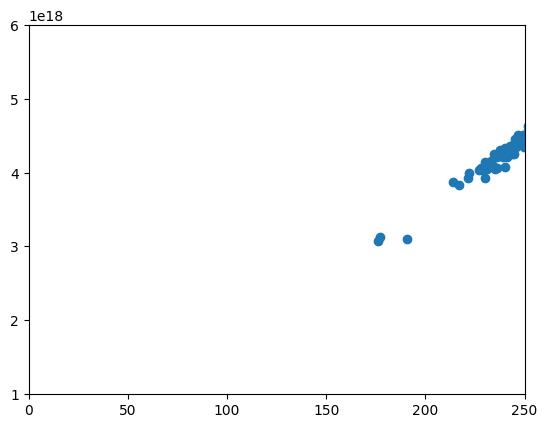

In [ ]:
#(110)
import matplotlib.pyplot as plt

x_list, y_list=[],[]
for x in range(len(preds_list)):
  x_list.append(preds_list[x][0])
  y_list.append(preds_list[x][1])
plt.xlim([0,250])
plt.ylim([1e18,6e18])
plt.scatter(x_list,y_list)

sum_mob = 0
sum_n   = 0
for i in range(len(preds_list)):
  sum_mob += preds_list[i][0]
  sum_n   += preds_list[i][1]

print(sum_mob/len(preds_list))
print(sum_n/len(preds_list))

161.5293806662445
3.578346245625565e+18


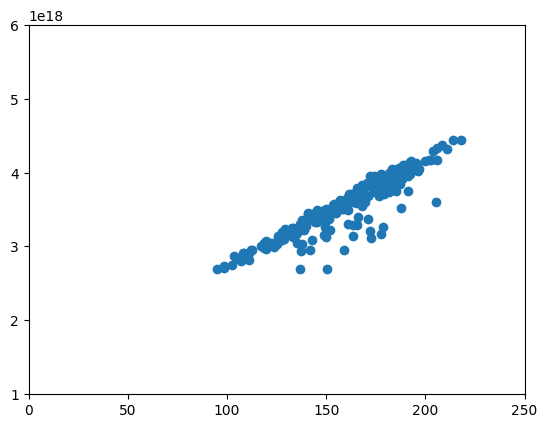

In [ ]:
#(111)
import matplotlib.pyplot as plt

x_list, y_list=[],[]
for x in range(len(preds_list)):
  x_list.append(preds_list[x][0])
  y_list.append(preds_list[x][1])
plt.xlim([0,250])
plt.ylim([1e18,6e18])
plt.scatter(x_list,y_list)

sum_mob = 0
sum_n   = 0
for i in range(len(preds_list)):
  sum_mob += preds_list[i][0]
  sum_n   += preds_list[i][1]

print(sum_mob/len(preds_list))
print(sum_n/len(preds_list))

In [ ]:
sample_paths=glob.glob(f"{DIR_PATH}/*")
for path in tqdm(sample_paths):
  sample_name=path.split("/")[-1]

  path_dict = {
  key:f"{DIR_PATH}/{sample_name}/{sample_name}_{key}.bmp"
    for key in ["BC","GB","IPF","SB","TC"]
  }

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
Path_orientation = '/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)'

for i in range(len(sample_paths)):
  print(Path_orientation+'/'+sample_paths[i].split('/')[-1])

/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)/SPC-Ge38
/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)/SPC-Ge26
/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)/SPC-Ge36
/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)/SPC-Ge37
/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)/SPC-Ge40
/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)/SPC-Ge39
/content/drive/MyDrive/03.移動度ML/01.As-doped/06.極値挿入/01.配向性の影響/(100)/SPC-Ge31


In [ ]:
np.mean(x_list)

192.66528839190678

In [ ]:
preds_list[0][0]

194.7140939829747

In [ ]:
H=820
W=1024
patch_size=224
data={
    "corner":[],
    "pred":[],
    }
for h_idx in trange(H//patch_size):
  for w_idx in trange(W//patch_size):
    #if num<10:
    corner = [h_idx*patch_size,w_idx*patch_size]

    data["corner"].append(corner)
    data["pred"].append(preds)

    # h_rangeも同じ

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
mu_zeros=np.zeros((14,18))
n_zeros=np.zeros((14,18))

for (corner,preds) in zip(data["corner"],data["pred"]):
  x=corner[1]//224
  y=corner[0]//224

  mu_zeros[y,x]=preds[0]
  n_zeros[y,x]=preds[1]

In [ ]:
image_mu=(mu_zeros-mu_zeros.min())/(mu_zeros.max()-mu_zeros.min())*255
image_mu=cv2.resize(image_mu,(952,728))
image_background=cv2.imread("/content/drive/MyDrive/03.移動度ML/01.As-doped/テストデータ/NGE18/NGE18_BC.bmp")
image_background=cv2.resize(image_background,(952,728))
alpha=0.1

image_background[:,:,0]=image_background[:,:,0]*alpha+image_mu*(1-alpha)
image_background[:,:,1]=image_background[:,:,1]*alpha+image_mu*(1-alpha)
image_background[:,:,2]=image_background[:,:,2]*alpha+image_mu*(1-alpha)
cv2_imshow(image_background)

NameError: ignored

In [ ]:
sample_name='NGE18'
path_dict={
      key:f"{DIR_PATH}/{sample_name}/{sample_name}_{key}.bmp"
        for key in ["BC","GB","IPF","SB","TC"]
      }
print(path_dict)
image = np.dstack([cv2.imread(path) for path in path_dict.values()])

{'BC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/NGE18/NGE18_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/NGE18/NGE18_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/NGE18/NGE18_IPF.bmp', 'SB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/NGE18/NGE18_SB.bmp', 'TC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/NGE18/NGE18_TC.bmp'}


In [ ]:
img=cv2.imread('/content/drive/MyDrive/03.移動度ML/01.As-doped/テストデータ/NGE18/NGE18_BC.bmp')

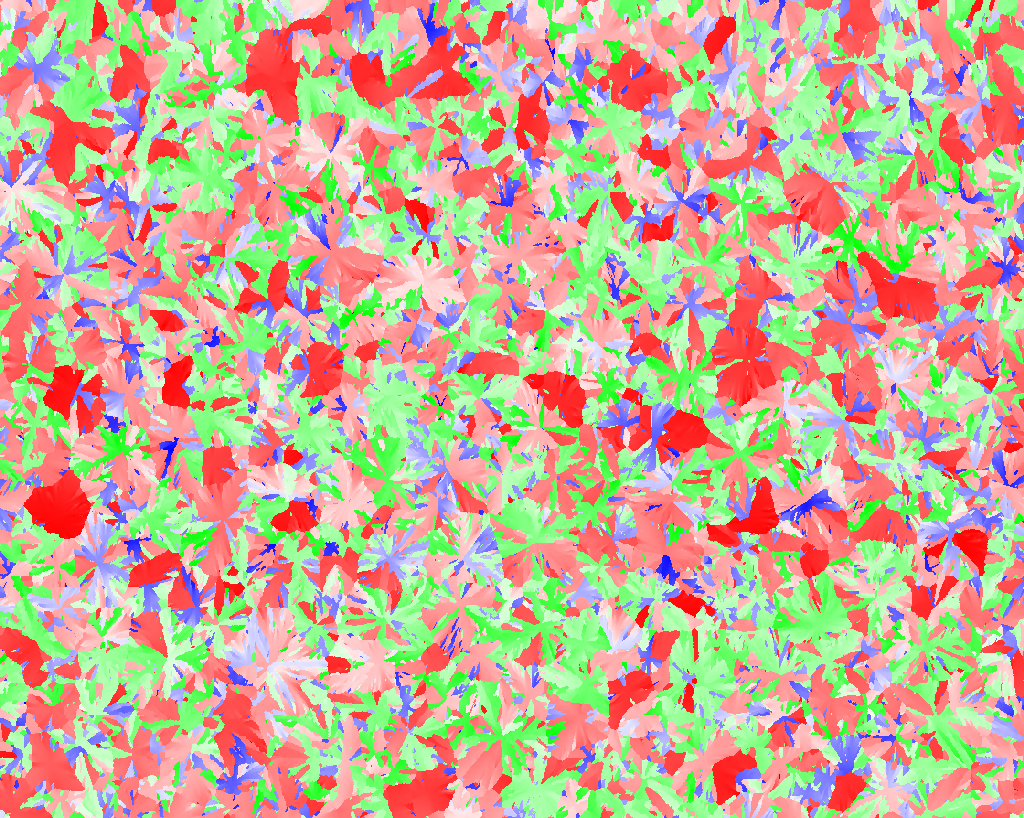

In [ ]:
image_files = [
    '/content/drive/MyDrive/03.移動度ML/01.As-doped/テストデータ/NGE18/NGE18_BC.bmp',
    '/content/drive/MyDrive/03.移動度ML/01.As-doped/テストデータ/NGE18/NGE18_GB.bmp',
    '/content/drive/MyDrive/03.移動度ML/01.As-doped/テストデータ/NGE18/NGE18_IPF.bmp',
    '/content/drive/MyDrive/03.移動度ML/01.As-doped/テストデータ/NGE18/NGE18_SB.bmp',
    '/content/drive/MyDrive/03.移動度ML/01.As-doped/テストデータ/NGE18/NGE18_TC.bmp'
]

images = [cv2.imread(image_file, cv2.IMREAD_UNCHANGED) for image_file in image_files]

# アルファチャンネルを持つ画像が混在している場合、すべての画像にアルファチャンネルを追加
for i, image in enumerate(images):
    if image.shape[2] == 3:
        images[i] = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)

# 最初の画像をベースにする
base_image = images[0].astype(np.float32)

# 2枚目以降の画像を重ねる
for image in images[1:]:
    alpha = image[:, :, 3] / 255.0
    alpha = np.expand_dims(alpha, axis=2)
    base_image = (1 - alpha) * base_image + alpha * image

cv2_imshow(base_image)

In [ ]:
H,W,_ = base_image.shape
patch_size = 224
n_H, n_W = H//patch_size, W//patch_size
H_, W_ = patch_size*n_H, patch_size*n_W
base_image = base_image[:H_, :W_]

In [ ]:
import cv2
import numpy as np
import random

# 画像の切り取りサイズを設定
crop_width, crop_height = 224, 224

# 切り取り回数を設定
num_crops = 10

# 切り取った画像を格納するリスト
cropped_images = []

for _ in range(num_crops):
    # ランダムな開始点を選ぶ
    start_x = random.randint(0, max(0, base_image.shape[1] - crop_width))
    start_y = random.randint(0, max(0, base_image.shape[0] - crop_height))

    # 画像を切り取る
    cropped_image = base_image[start_y:min(start_y + crop_height, base_image.shape[0]),
                               start_x:min(start_x + crop_width, base_image.shape[1])]

    # 切り取りサイズが不足している場合、ゼロパディングを追加
    if cropped_image.shape[0] < crop_height or cropped_image.shape[1] < crop_width:
        padded_image = np.zeros((crop_height, crop_width, cropped_image.shape[2]), dtype=cropped_image.dtype)
        padded_image[:cropped_image.shape[0], :cropped_image.shape[1]] = cropped_image
        cropped_image = padded_image

    # 切り取った画像をリストに追加
    cropped_images.append(cropped_image)


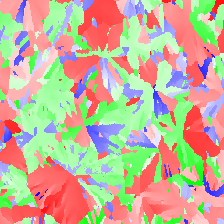

In [ ]:
cv2_imshow(cropped_images[3])

In [ ]:
cropped_images[0].shape

(224, 224, 4)

In [ ]:
import os
import tempfile

# データタイプを float32 に変換
cropped_image_float32 = cropped_images[0].astype(np.float32)

# アルファチャンネルを削除してBGR形式にする
cropped_image_bgr = cv2.cvtColor(cropped_image_float32[:, :, :3], cv2.COLOR_BGRA2BGR)

# データタイプを uint8 に変換（0～255にクリップしてから）
cropped_image_uint8 = np.clip(cropped_image_bgr * 255, 0, 255).astype(np.uint8)

# 切り取った画像を一時ファイルに保存
with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_file:
    temp_path = temp_file.name
    cv2.imwrite(temp_path, cropped_image_uint8)

# 一時ファイルのパスを model.predict() に渡す
result = model.predict(temp_path, "cuda:0" if torch.cuda.is_available() else "cpu", trainval_dataset.mu_range, trainval_dataset.n_range, [0, 0])

# 一時ファイルを削除
os.remove(temp_path)

{'BC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/tmpfisurpvm.png/tmpfisurpvm.png_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/tmpfisurpvm.png/tmpfisurpvm.png_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/tmpfisurpvm.png/tmpfisurpvm.png_IPF.bmp', 'SB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/tmpfisurpvm.png/tmpfisurpvm.png_SB.bmp', 'TC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/tmpfisurpvm.png/tmpfisurpvm.png_TC.bmp'}


TypeError: ignored

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
#for k, (train_idx, valid_idx) in enumerate(kf.split(trainval_dataset)):
  #break

model.predict("/content/drive/MyDrive/03.移動度ML/01.As-doped/04.AsdopedGe/データ/テストデータ/NGE18","cuda:0" if torch.cuda.is_available() else "cpu",trainval_dataset.mu_range, trainval_dataset.n_range,[0,0])

{'BC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/NGE18/NGE18_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/NGE18/NGE18_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/NGE18/NGE18_IPF.bmp', 'SB': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/NGE18/NGE18_SB.bmp', 'TC': '/content/drive/MyDrive/03.移動度ML/01.As-doped/学習データ/NGE18/NGE18_TC.bmp'}


TypeError: ignored

In [ ]:
a=cropped_images[0].astype(np.uint8)
a.shape

(224, 224, 4)

In [ ]:
patch_size=224
H=820
W=1024
data={
    "corner":[],
    "pred":[],
    }
for h_idx in trange(H//patch_size):
  for w_idx in trange(W//patch_size):
    #if num<10:
    corner = [h_idx*patch_size,w_idx*patch_size]
    preds=model.predict(a,"cuda:0" if torch.cuda.is_available() else "cpu",trainval_dataset.mu_range, trainval_dataset.n_range,corner)
    data["corner"].append(corner)
    data["pred"].append(preds)

    # h_rangeも同じ

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

AttributeError: ignored

In [ ]:
mu_zeros=np.zeros((14,18))
n_zeros=np.zeros((14,18))

for (corner,preds) in zip(data["corner"],data["pred"]):
  x=corner[1]//224
  y=corner[0]//224

  mu_zeros[y,x]=preds[0]
  n_zeros[y,x]=preds[1]

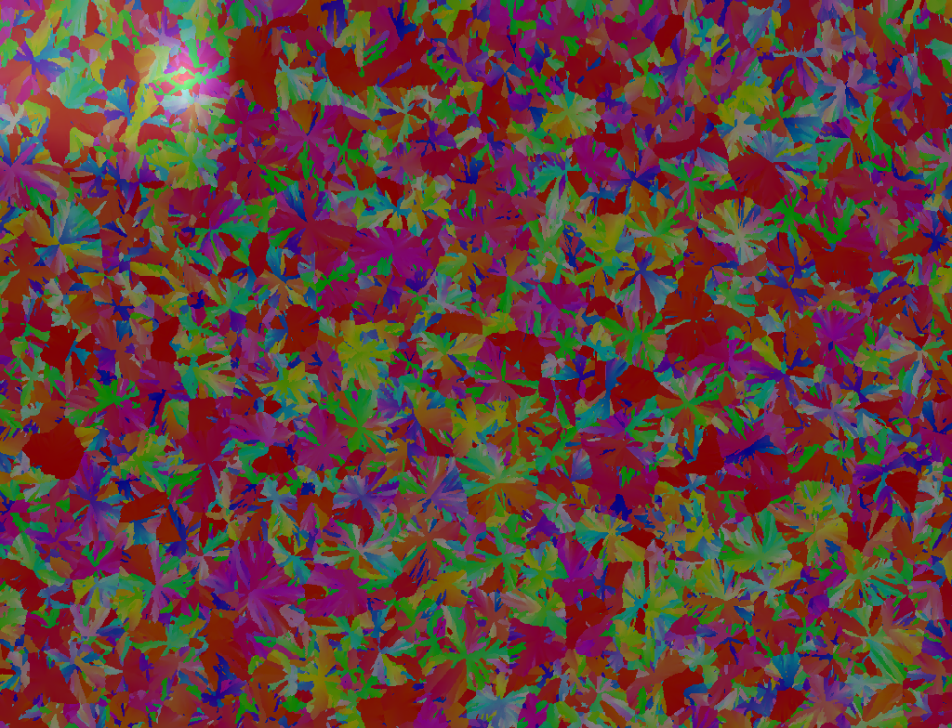

In [ ]:
image_mu=(mu_zeros-mu_zeros.min())/(mu_zeros.max()-mu_zeros.min())*255
image_mu=cv2.resize(image_mu,(952,728))
image_background=cv2.imread("/content/drive/MyDrive/03.移動度ML/01.As-doped/テストデータ/NGE18/NGE18_IPF.bmp")
image_background=cv2.resize(image_background,(952,728))
alpha=0.5
image_background[:,:,0]=image_background[:,:,0]*alpha+image_mu*(1-alpha)
image_background[:,:,1]=image_background[:,:,1]*alpha+image_mu*(1-alpha)
image_background[:,:,2]=image_background[:,:,2]*alpha+image_mu*(1-alpha)
cv2_imshow(image_background)

In [ ]:
image_mu=(n_zeros-n_zeros.min())/(n_zeros.max()-n_zeros.min())*255
image_mu=cv2.resize(image_mu,(952,728))
image_background=cv2.imread("/content/drive/MyDrive/03.移動度ML/04.AsdopedGe/データ/SPC-Ge36/SPC-Ge36_IPF.bmp")
image_background=cv2.resize(image_background,(952,728))
alpha=0.5
image_background[:,:,0]=image_background[:,:,0]*alpha+image_mu*(1-alpha)
image_background[:,:,1]=image_background[:,:,1]*alpha+image_mu*(1-alpha)
image_background[:,:,2]=image_background[:,:,2]*alpha+image_mu*(1-alpha)
cv2_imshow(image_background)

error: ignored

In [ ]:
np.max(np.array(data["corner"]), axis=0)

array([728, 952])

In [ ]:
cv2.imread("/content/drive/MyDrive/03.移動度ML/04.AsdopedGe/データ/SPC-Ge26/SPC-Ge26_BC.bmp").shape

(819, 1024, 3)

In [ ]:
sample_names=[]
mu_True=[]
n_True=[]
mu_pred=[]
n_pred=[]
num_sample=50

for _, row in df.iloc[valid_idx].iterrows():
  for _ in trange(num_sample):
    PATH_tmp=f"/content/drive/MyDrive/03.移動度ML/04.AsdopedGe/データ/"
    mu_pred_tmp, n_pred_tmp = model.predict(PATH_tmp, device)

    mu_pred.append(mu_pred_tmp)
    n_pred.append(n_pred_tmp)

    mu_True.append(row["移動度"])
    n_True.append(row["キャリア密度"])
    sample_names.append(row["サンプル名"])
df_result=pd.DataFrame(
    data={
        "サンプル名":sample_names,
      "移動度_実験値":mu_True,
    "電子密度_実験値":n_True,
      "移動度_予測値":mu_pred,
    "電子密度_予測値":n_pred,
    }
)



IndexError: ignored